In [1]:
#添加Atrous Spatial Pyramid Pooling (ASPP) ，添加复合注意力结构CBAM + ECA（Efficient Channel Attention），
#替换 RSU 模块中的普通卷积为 Depthwise Separable Convolution；
#在 Encoder-Decoder 跳跃连接中加入 CBAM 或通道选择机制，减少低层特征干扰，使用Hausdorff Distance Loss。给我完整代码


In [2]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import cv2
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

from kornia.losses import HausdorffERLoss as HausdorffDistanceLoss

# ---------- Depthwise Separable Convolution ----------
class SeparableConv2d(nn.Module):
    def __init__(self, in_ch, out_ch, kernel_size=3, padding=1, dilation=1, bias=False):
        super().__init__()
        self.depthwise = nn.Conv2d(in_ch, in_ch, kernel_size, padding=padding*dilation,
                                   dilation=dilation, groups=in_ch, bias=bias)
        self.pointwise = nn.Conv2d(in_ch, out_ch, 1, bias=bias)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x

# ---------- Attention Modules ----------
class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=8):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc = nn.Sequential(
            nn.Conv2d(in_planes, in_planes//ratio, 1, bias=False),
            nn.ReLU(),
            nn.Conv2d(in_planes//ratio, in_planes, 1, bias=False)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg = self.fc(self.avg_pool(x))
        mx  = self.fc(self.max_pool(x))
        return self.sigmoid(avg + mx)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super().__init__()
        padding = kernel_size // 2
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg = torch.mean(x, dim=1, keepdim=True)
        mx, _ = torch.max(x, dim=1, keepdim=True)
        x_cat = torch.cat([avg, mx], dim=1)
        return self.sigmoid(self.conv(x_cat))

class ECALayer(nn.Module):
    def __init__(self, channels, k_size=3):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.conv = nn.Conv1d(1, 1, k_size, padding=(k_size-1)//2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        y = self.avg_pool(x)             # B, C, 1, 1
        y = y.squeeze(-1).transpose(-1, -2)  # B, 1, C
        y = self.conv(y)                 # B, 1, C
        y = self.sigmoid(y).transpose(-1, -2).unsqueeze(-1)  # B, C, 1, 1
        return x * y.expand_as(x)

class CompositeAttention(nn.Module):
    def __init__(self, channels, reduction=8, k_size=3):
        super().__init__()
        self.ca = ChannelAttention(channels, ratio=reduction)
        self.sa = SpatialAttention()
        self.eca = ECALayer(channels, k_size=k_size)

    def forward(self, x):
        x = x * self.ca(x)
        x = x * self.sa(x)
        x = self.eca(x)
        return x

# ---------- Atrous Spatial Pyramid Pooling (ASPP) ----------
class ASPP(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 1)
        self.conv2 = nn.Conv2d(in_ch, out_ch, 3, padding=6, dilation=6)
        self.conv3 = nn.Conv2d(in_ch, out_ch, 3, padding=12, dilation=12)
        self.conv4 = nn.Conv2d(in_ch, out_ch, 3, padding=18, dilation=18)
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.pool_conv = nn.Conv2d(in_ch, out_ch, 1)
        self.out = nn.Conv2d(out_ch*5, out_ch, 1)
        self.bn = nn.BatchNorm2d(out_ch)
        self.relu = nn.ReLU()

    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.conv2(x)
        x3 = self.conv3(x)
        x4 = self.conv4(x)
        x5 = self.pool(x)
        x5 = self.pool_conv(x5)
        x5 = F.interpolate(x5, size=x4.shape[2:], mode='bilinear', align_corners=False)
        x = torch.cat([x1, x2, x3, x4, x5], dim=1)
        x = self.out(x)
        x = self.bn(x)
        return self.relu(x)

# ---------- Modified U2NET Blocks ----------
class REBNCONV(nn.Module):
    def __init__(self, in_ch, out_ch, dirate=1):
        super().__init__()
        self.conv = nn.Sequential(
            SeparableConv2d(in_ch, out_ch, kernel_size=3, padding=dirate, dilation=dirate),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )
        self.att = CompositeAttention(out_ch)

    def forward(self, x):
        x = self.conv(x)
        return self.att(x)

class RSU7(nn.Module):
    def __init__(self, in_ch, mid_ch, out_ch):
        super().__init__()
        self.rebnconvin = REBNCONV(in_ch, out_ch)
        self.stage1 = REBNCONV(out_ch, mid_ch)
        self.pool1  = nn.MaxPool2d(2, stride=2, ceil_mode=True)
        self.stage2 = REBNCONV(mid_ch, mid_ch)
        self.pool2  = nn.MaxPool2d(2, stride=2, ceil_mode=True)
        self.stage3 = REBNCONV(mid_ch, mid_ch)
        self.pool3  = nn.MaxPool2d(2, stride=2, ceil_mode=True)
        self.stage4 = REBNCONV(mid_ch, mid_ch)
        self.pool4  = nn.MaxPool2d(2, stride=2, ceil_mode=True)
        self.stage5 = REBNCONV(mid_ch, mid_ch)
        self.pool5  = nn.MaxPool2d(2, stride=2, ceil_mode=True)
        self.stage6 = REBNCONV(mid_ch, mid_ch)
        self.pool6  = nn.MaxPool2d(2, stride=2, ceil_mode=True)
        self.stage7 = REBNCONV(mid_ch, mid_ch)

        # Decoder stages
        self.stage6d = REBNCONV(mid_ch*2, mid_ch)
        self.stage5d = REBNCONV(mid_ch*2, mid_ch)
        self.stage4d = REBNCONV(mid_ch*2, mid_ch)
        self.stage3d = REBNCONV(mid_ch*2, mid_ch)
        self.stage2d = REBNCONV(mid_ch*2, mid_ch)
        self.stage1d = REBNCONV(mid_ch*2, out_ch)

    def forward(self, x):
        hxin = self.rebnconvin(x)
        hx1  = self.stage1(hxin)
        hx2  = self.stage2(self.pool1(hx1))
        hx3  = self.stage3(self.pool2(hx2))
        hx4  = self.stage4(self.pool3(hx3))
        hx5  = self.stage5(self.pool4(hx4))
        hx6  = self.stage6(self.pool5(hx5))
        hx7  = self.stage7(self.pool6(hx6))

        hx6d = self.stage6d(torch.cat([F.interpolate(hx7, size=hx6.shape[2:], mode='bilinear', align_corners=False), hx6], dim=1))
        hx5d = self.stage5d(torch.cat([F.interpolate(hx6d, size=hx5.shape[2:], mode='bilinear', align_corners=False), hx5], dim=1))
        hx4d = self.stage4d(torch.cat([F.interpolate(hx5d, size=hx4.shape[2:], mode='bilinear', align_corners=False), hx4], dim=1))
        hx3d = self.stage3d(torch.cat([F.interpolate(hx4d, size=hx3.shape[2:], mode='bilinear', align_corners=False), hx3], dim=1))
        hx2d = self.stage2d(torch.cat([F.interpolate(hx3d, size=hx2.shape[2:], mode='bilinear', align_corners=False), hx2], dim=1))
        hx1d = self.stage1d(torch.cat([F.interpolate(hx2d, size=hx1.shape[2:], mode='bilinear', align_corners=False), hx1], dim=1))

        return hx1d + hxin

class U2NET(nn.Module):
    def __init__(self, in_ch=3, out_ch=1):
        super().__init__()
        self.stage1 = RSU7(in_ch, 32, 64)
        self.aspp   = ASPP(64, 64)
        self.outconv= nn.Conv2d(64, out_ch, 1)

    def forward(self, x):
        x = self.stage1(x)
        x = self.aspp(x)
        x = self.outconv(x)
        return torch.sigmoid(x)

# ---------- Dataset & DataLoader ----------
class HairMaskDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform_img=None, transform_mask=None):
        self.image_list = sorted([f for f in os.listdir(image_dir) if f.endswith('.jpg')])
        self.image_dir = image_dir
        self.mask_dir  = mask_dir
        self.transform_img  = transform_img
        self.transform_mask = transform_mask

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        img_name = self.image_list[idx]
        img = Image.open(os.path.join(self.image_dir, img_name)).convert('RGB')
        msk = Image.open(os.path.join(self.mask_dir, img_name)).convert('L')
        if self.transform_img:
            img = self.transform_img(img)
        if self.transform_mask:
            msk = self.transform_mask(msk)
        return img, msk

# Transforms
transform_img  = transforms.Compose([transforms.Resize((256,256)), transforms.ToTensor()])
transform_mask = transforms.Compose([transforms.Resize((256,256)), transforms.ToTensor()])

# Paths
image_dir = "/root/autodl-fs/skin_hair_dataset/alignment/photo with hair"
mask_dir  = "/root/autodl-fs/skin_hair_dataset/alignment/mask"

dataset = HairMaskDataset(image_dir, mask_dir, transform_img, transform_mask)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=4)

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Model, Loss, Optimizer
model = U2NET().to(device)
loss_fn = HausdorffERLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# ---------- Training Loop ----------
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for imgs, masks in dataloader:
        imgs, masks = imgs.to(device), masks.to(device)
        preds = model(imgs)
        preds_cat = torch.cat([1 - preds, preds], dim=1)      # [B,2,H,W]
        target    = masks.long()                  # [B,H,W], 值为 0 或 1
        loss      = loss_fn(preds_cat, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(dataloader):.4f}")

# Save the model
os.makedirs("./checkpoints", exist_ok=True)
model_path = "./checkpoints/hair_seg_u2net_optimized.pth"
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")

# ---------- Inference & Inpainting ----------
def inpaint_image(image_path, save_path=None):
    model.eval()
    image = Image.open(image_path).convert('RGB').resize((256,256))
    inp   = transform_img(image).unsqueeze(0).to(device)
    with torch.no_grad():
        pred_mask = model(inp).squeeze().cpu().numpy()
    binary_mask = (pred_mask > 0.5).astype(np.uint8)*255
    img_cv = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
    inpainted = cv2.inpaint(img_cv, binary_mask, 3, cv2.INPAINT_TELEA)
    if save_path:
        cv2.imwrite(save_path, inpainted)
    return img_cv, binary_mask, inpainted

# Example inference
save_dir = "./inpainted_results"
os.makedirs(save_dir, exist_ok=True)
for img_name in ["ISIC2019_0000461.jpg", "ISIC2019_0031696.jpg", "ISIC2019_0028326.jpg"]:
    src = os.path.join(image_dir, img_name)
    _, _, res = inpaint_image(src, os.path.join(save_dir, f"inpainted_{img_name}"))
    print(f"Saved inpainted_{img_name} to {save_dir}")
    # visualize
    plt.figure(figsize=(6,6))
    plt.imshow(cv2.cvtColor(res, cv2.COLOR_BGR2RGB))
    plt.title(f"Inpainted {img_name}")
    plt.axis('off')
    plt.show()


NameError: name 'HausdorffERLoss' is not defined

In [ ]:
#添加Atrous Spatial Pyramid Pooling (ASPP) ，添加复合注意力结构CBAM + ECA（Efficient Channel Attention），
#替换 RSU 模块中的普通卷积为 Depthwise Separable Convolution；

Epoch 1: Loss = 0.9092
Epoch 2: Loss = 0.8938
Epoch 3: Loss = 0.8763
Epoch 4: Loss = 0.8641
Epoch 5: Loss = 0.8494
Epoch 6: Loss = 0.8395
Epoch 7: Loss = 0.8284
Epoch 8: Loss = 0.8226
Epoch 9: Loss = 0.8115
Epoch 10: Loss = 0.8033
Epoch 11: Loss = 0.7984
Epoch 12: Loss = 0.7854
Epoch 13: Loss = 0.7801
Epoch 14: Loss = 0.7681
Epoch 15: Loss = 0.7619
Epoch 16: Loss = 0.7529
Epoch 17: Loss = 0.7419
Epoch 18: Loss = 0.7365
Epoch 19: Loss = 0.7224
Epoch 20: Loss = 0.7143
Epoch 21: Loss = 0.7077
Epoch 22: Loss = 0.6963
Epoch 23: Loss = 0.6849
Epoch 24: Loss = 0.6746
Epoch 25: Loss = 0.6612
Epoch 26: Loss = 0.6591
Epoch 27: Loss = 0.6491
Epoch 28: Loss = 0.6358
Epoch 29: Loss = 0.6273
Epoch 30: Loss = 0.6189
Epoch 31: Loss = 0.6080
Epoch 32: Loss = 0.5935
Epoch 33: Loss = 0.5787
Epoch 34: Loss = 0.5682
Epoch 35: Loss = 0.5609
Epoch 36: Loss = 0.5567
Epoch 37: Loss = 0.5439
Epoch 38: Loss = 0.5334
Epoch 39: Loss = 0.5158
Epoch 40: Loss = 0.5135
Epoch 41: Loss = 0.4991
Epoch 42: Loss = 0.4922
E

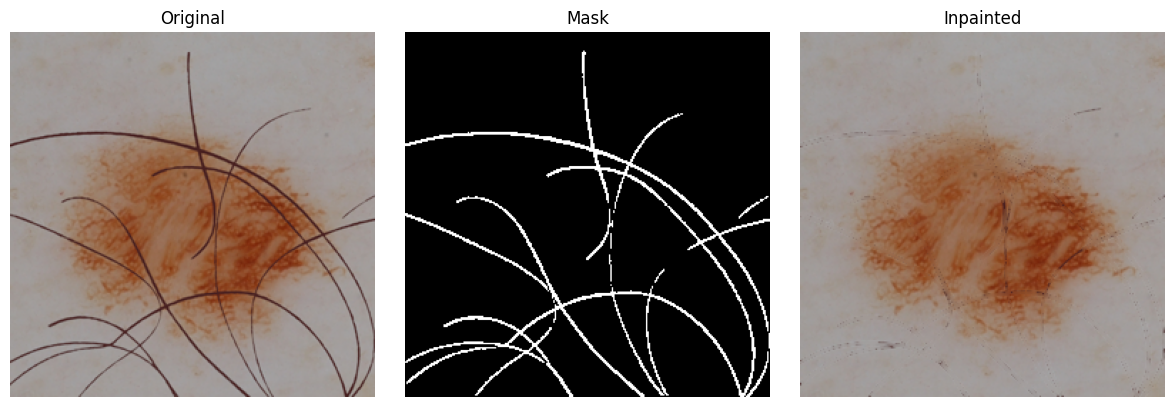

✅ 已保存：./inpainted_results/inpainted_ISIC2019_0031696.jpg


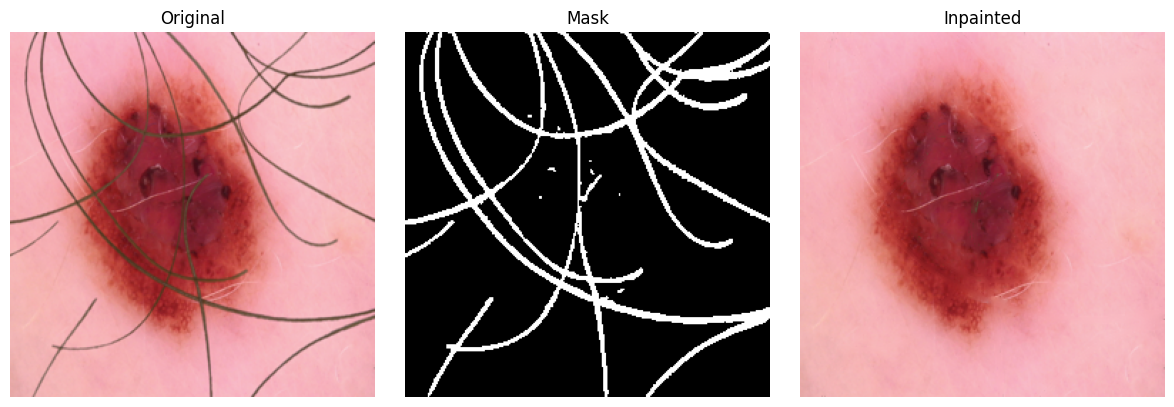

✅ 已保存：./inpainted_results/inpainted_ISIC2019_0028326.jpg


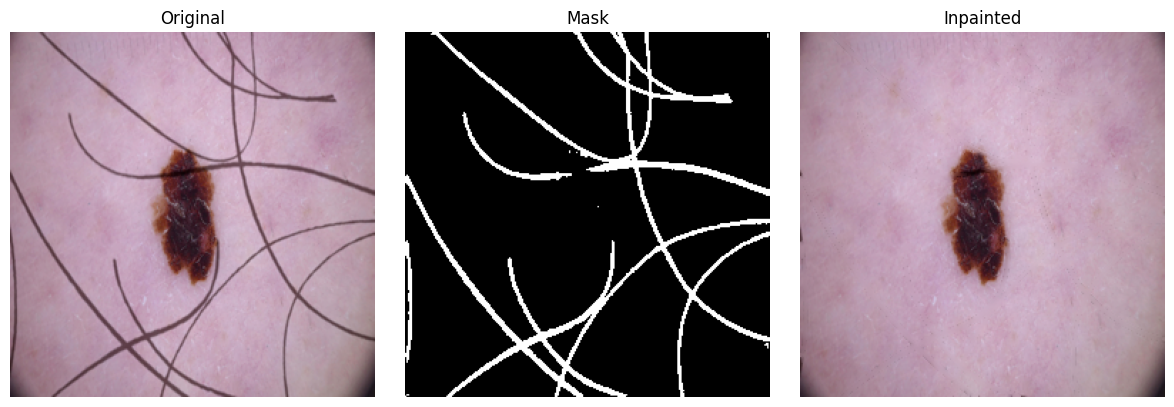

In [3]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import cv2
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# ---------- Depthwise Separable Convolution ----------
class SeparableConv2d(nn.Module):
    def __init__(self, in_ch, out_ch, kernel_size=3, padding=1, dilation=1, bias=False):
        super().__init__()
        self.depthwise = nn.Conv2d(in_ch, in_ch, kernel_size, padding=padding*dilation,
                                   dilation=dilation, groups=in_ch, bias=bias)
        self.pointwise = nn.Conv2d(in_ch, out_ch, 1, bias=bias)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x

# ---------- Composite Attention (CBAM + ECA) ----------
class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=8):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc = nn.Sequential(
            nn.Conv2d(in_planes, in_planes//ratio, 1, bias=False),
            nn.ReLU(),
            nn.Conv2d(in_planes//ratio, in_planes, 1, bias=False)
        )
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        avg = self.fc(self.avg_pool(x))
        mx  = self.fc(self.max_pool(x))
        return self.sigmoid(avg + mx)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super().__init__()
        padding = kernel_size // 2
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        avg = torch.mean(x, dim=1, keepdim=True)
        mx, _ = torch.max(x, dim=1, keepdim=True)
        x_cat = torch.cat([avg, mx], dim=1)
        return self.sigmoid(self.conv(x_cat))

class ECALayer(nn.Module):
    def __init__(self, channels, k_size=3):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.conv = nn.Conv1d(1, 1, k_size, padding=(k_size-1)//2, bias=False)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        y = self.avg_pool(x).squeeze(-1).transpose(-1, -2)
        y = self.conv(y)
        y = self.sigmoid(y).transpose(-1, -2).unsqueeze(-1)
        return x * y.expand_as(x)

class CompositeAttention(nn.Module):
    def __init__(self, channels, reduction=8, k_size=3):
        super().__init__()
        self.ca  = ChannelAttention(channels, ratio=reduction)
        self.sa  = SpatialAttention()
        self.eca = ECALayer(channels, k_size)
    def forward(self, x):
        x = x * self.ca(x)
        x = x * self.sa(x)
        x = self.eca(x)
        return x

# ---------- Atrous Spatial Pyramid Pooling ----------
class ASPP(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 1)
        self.conv2 = nn.Conv2d(in_ch, out_ch, 3, padding=6, dilation=6)
        self.conv3 = nn.Conv2d(in_ch, out_ch, 3, padding=12, dilation=12)
        self.conv4 = nn.Conv2d(in_ch, out_ch, 3, padding=18, dilation=18)
        self.pool  = nn.AdaptiveAvgPool2d(1)
        self.pool_conv = nn.Conv2d(in_ch, out_ch, 1)
        self.out   = nn.Conv2d(out_ch*5, out_ch, 1)
        self.bn    = nn.BatchNorm2d(out_ch)
        self.relu  = nn.ReLU()
    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.conv2(x)
        x3 = self.conv3(x)
        x4 = self.conv4(x)
        x5 = self.pool(x)
        x5 = self.pool_conv(x5)
        x5 = F.interpolate(x5, size=x4.shape[2:], mode='bilinear', align_corners=False)
        x  = torch.cat([x1, x2, x3, x4, x5], dim=1)
        x  = self.out(x)
        x  = self.bn(x)
        return self.relu(x)

# ---------- Modified U2NET Blocks ----------
class REBNCONV(nn.Module):
    def __init__(self, in_ch, out_ch, dirate=1):
        super().__init__()
        self.conv = nn.Sequential(
            SeparableConv2d(in_ch, out_ch, kernel_size=3, padding=dirate, dilation=dirate),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )
        self.att  = CompositeAttention(out_ch)
    def forward(self, x):
        x = self.conv(x)
        return self.att(x)

class REBNCONV_NoAtt(nn.Module):
    def __init__(self, in_ch, out_ch, dirate=1):
        super().__init__()
        self.conv = nn.Sequential(
            SeparableConv2d(in_ch, out_ch, kernel_size=3, padding=dirate, dilation=dirate),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.conv(x)

class RSU7(nn.Module):
    def __init__(self, in_ch, mid_ch, out_ch):
        super().__init__()
        # Encoder
        self.rebnconvin = REBNCONV(in_ch, out_ch)
        self.stage1     = REBNCONV(out_ch, mid_ch)
        self.pool1      = nn.MaxPool2d(2, stride=2, ceil_mode=True)
        self.stage2     = REBNCONV(mid_ch, mid_ch)
        self.pool2      = nn.MaxPool2d(2, stride=2, ceil_mode=True)
        self.stage3     = REBNCONV(mid_ch, mid_ch)
        self.pool3      = nn.MaxPool2d(2, stride=2, ceil_mode=True)
        self.stage4     = REBNCONV(mid_ch, mid_ch)
        self.pool4      = nn.MaxPool2d(2, stride=2, ceil_mode=True)
        self.stage5     = REBNCONV(mid_ch, mid_ch)
        self.pool5      = nn.MaxPool2d(2, stride=2, ceil_mode=True)
        self.stage6     = REBNCONV(mid_ch, mid_ch)
        self.pool6      = nn.MaxPool2d(2, stride=2, ceil_mode=True)
        self.stage7     = REBNCONV(mid_ch, mid_ch)
        # Decoder (no skip-attention)
        self.stage6d    = REBNCONV_NoAtt(mid_ch*2, mid_ch)
        self.stage5d    = REBNCONV_NoAtt(mid_ch*2, mid_ch)
        self.stage4d    = REBNCONV_NoAtt(mid_ch*2, mid_ch)
        self.stage3d    = REBNCONV_NoAtt(mid_ch*2, mid_ch)
        self.stage2d    = REBNCONV_NoAtt(mid_ch*2, mid_ch)
        self.stage1d    = REBNCONV_NoAtt(mid_ch*2, out_ch)
    def forward(self, x):
        hxin = self.rebnconvin(x)
        hx1  = self.stage1(hxin)
        hx2  = self.stage2(self.pool1(hx1))
        hx3  = self.stage3(self.pool2(hx2))
        hx4  = self.stage4(self.pool3(hx3))
        hx5  = self.stage5(self.pool4(hx4))
        hx6  = self.stage6(self.pool5(hx5))
        hx7  = self.stage7(self.pool6(hx6))
        hx6d = self.stage6d(torch.cat([F.interpolate(hx7, size=hx6.shape[2:], mode='bilinear', align_corners=False), hx6], dim=1))
        hx5d = self.stage5d(torch.cat([F.interpolate(hx6d, size=hx5.shape[2:], mode='bilinear', align_corners=False), hx5], dim=1))
        hx4d = self.stage4d(torch.cat([F.interpolate(hx5d, size=hx4.shape[2:], mode='bilinear', align_corners=False), hx4], dim=1))
        hx3d = self.stage3d(torch.cat([F.interpolate(hx4d, size=hx3.shape[2:], mode='bilinear', align_corners=False), hx3], dim=1))
        hx2d = self.stage2d(torch.cat([F.interpolate(hx3d, size=hx2.shape[2:], mode='bilinear', align_corners=False), hx2], dim=1))
        hx1d = self.stage1d(torch.cat([F.interpolate(hx2d, size=hx1.shape[2:], mode='bilinear', align_corners=False), hx1], dim=1))
        return hx1d + hxin

class U2NET(nn.Module):
    def __init__(self, in_ch=3, out_ch=1):
        super().__init__()
        self.stage1  = RSU7(in_ch, 32, 64)
        self.aspp    = ASPP(64, 64)
        self.outconv = nn.Conv2d(64, out_ch, 1)
    def forward(self, x):
        x = self.stage1(x)
        x = self.aspp(x)
        x = self.outconv(x)
        return torch.sigmoid(x)

# ---------- Dice Loss ----------
def dice_loss(pred, target, smooth=1.):
    pred_flat   = pred.contiguous().view(-1)
    target_flat = target.contiguous().view(-1)
    intersection= (pred_flat * target_flat).sum()
    return 1 - (2.*intersection + smooth) / (pred_flat.sum() + target_flat.sum() + smooth)

# ---------- Dataset & Loader ----------
class HairMaskDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform_img=None, transform_mask=None):
        self.image_list = sorted([f for f in os.listdir(image_dir) if f.endswith('.jpg')])
        self.image_dir  = image_dir
        self.mask_dir   = mask_dir
        self.transform_img  = transform_img
        self.transform_mask = transform_mask
    def __len__(self):
        return len(self.image_list)
    def __getitem__(self, idx):
        name = self.image_list[idx]
        img  = Image.open(os.path.join(self.image_dir, name)).convert('RGB')
        msk  = Image.open(os.path.join(self.mask_dir, name)).convert('L')
        if self.transform_img:  img = self.transform_img(img)
        if self.transform_mask: msk = self.transform_mask(msk)
        return img, msk

# Transforms
transform_img  = transforms.Compose([transforms.Resize((256,256)), transforms.ToTensor()])
transform_mask = transforms.Compose([transforms.Resize((256,256)), transforms.ToTensor()])

# Paths
dirs = {
    'image_dir': "/root/autodl-fs/skin_hair_dataset/alignment/photo with hair",
    'mask_dir' : "/root/autodl-fs/skin_hair_dataset/alignment/mask",
    'save_dir' : "./inpainted_results"
}
# Data
dataset  = HairMaskDataset(dirs['image_dir'], dirs['mask_dir'], transform_img, transform_mask)
loader   = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=4)
# Device
device   = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Model
model    = U2NET().to(device)
optimizer= torch.optim.Adam(model.parameters(), lr=1e-4)
# Train
for epoch in range(120):
    model.train()
    tot_loss = 0
    for imgs, msks in loader:
        imgs, msks = imgs.to(device), msks.to(device)
        preds      = model(imgs)
        loss       = dice_loss(preds, msks)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        tot_loss  += loss.item()
    print(f"Epoch {epoch+1}: Loss = {tot_loss/len(loader):.4f}")
# Save
os.makedirs("./checkpoints", exist_ok=True)
pth = "./checkpoints/hair_seg_u2net_opt.pth"
torch.save(model.state_dict(), pth)
print(f"Model saved: {pth}")

# Inference & Inpainting
def inpaint_image(path, save_path=None):
    model.eval()
    img      = Image.open(path).convert('RGB').resize((256,256))
    inp      = transform_img(img).unsqueeze(0).to(device)
    with torch.no_grad(): pred_mask = model(inp).squeeze().cpu().numpy()
    bin_mask = (pred_mask>0.5).astype(np.uint8)*255
    img_cv   = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    res      = cv2.inpaint(img_cv, bin_mask, 3, cv2.INPAINT_TELEA)
    if save_path: cv2.imwrite(save_path, res)
    return img_cv, bin_mask, res
test_images = ['ISIC2019_0000461.jpg', 'ISIC2019_0031696.jpg', 'ISIC2019_0028326.jpg']
test_dir = "/root/autodl-fs/skin_hair_dataset/alignment/photo with hair"
save_dir = "./inpainted_results"  # 保存目录

# 创建保存目录
os.makedirs(save_dir, exist_ok=True)

for img_name in test_images:
    img_path = os.path.join(test_dir, img_name)
    
    # 获取原图、掩码、修复图像
    original, mask, inpainted = inpaint_image(img_path)
    
    # 保存 inpainted 图像
    save_path = os.path.join(save_dir, f"inpainted_{img_name}")
    cv2.imwrite(save_path, inpainted)
    print(f"✅ 已保存：{save_path}")
    
    # 可视化显示
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB)); plt.title("Original"); plt.axis("off")
    plt.subplot(1, 3, 2)
    plt.imshow(mask, cmap="gray"); plt.title("Mask"); plt.axis("off")
    plt.subplot(1, 3, 3)
    plt.imshow(cv2.cvtColor(inpainted, cv2.COLOR_BGR2RGB)); plt.title("Inpainted"); plt.axis("off")
    plt.tight_layout(); plt.show()


In [4]:
from skimage.metrics import mean_squared_error, peak_signal_noise_ratio, structural_similarity
from sewar.full_ref import uqi

# ---------- 7. 图像质量指标计算函数 ----------
def calculate_metrics(pred_img, gt_img):
    pred_img = pred_img.astype(np.float32) / 255.0
    gt_img = gt_img.astype(np.float32) / 255.0

    h, w = pred_img.shape[:2]
    win_size = min(7, h, w)
    if win_size % 2 == 0:
        win_size -= 1

    mse = mean_squared_error(gt_img, pred_img)
    psnr = peak_signal_noise_ratio(gt_img, pred_img, data_range=1.0)
    ssim = structural_similarity(gt_img, pred_img, data_range=1.0, channel_axis=2, win_size=win_size)
    uqi_val = uqi(gt_img, pred_img)

    return mse, psnr, ssim, uqi_val
image_dir = "/root/autodl-fs/skin_hair_dataset/alignment/photo with hair"
original_dir = "/root/autodl-fs/skin_hair_dataset/alignment/oryginal"  # 没有毛发的 ground-truth 原图
image_list = sorted([f for f in os.listdir(image_dir) if f.endswith('.jpg')])

# 累加指标
total_mse, total_psnr, total_ssim, total_uqi = 0, 0, 0, 0
valid_count = 0

for img_name in image_list:
    try:
        # 推理修复图像
        img_path = os.path.join(image_dir, img_name)
        original, _, inpainted = inpaint_image(img_path)

        # 加载 ground-truth（无毛发）图像
        gt_path = os.path.join(original_dir, img_name)
        if not os.path.exists(gt_path):
            print(f"❌ ground-truth 缺失: {img_name}")
            continue
        gt_img = cv2.imread(gt_path)
        gt_img = cv2.resize(gt_img, (256, 256))

        # 计算指标
        mse, psnr, ssim, uqi_val = calculate_metrics(inpainted, gt_img)
        total_mse += mse
        total_psnr += psnr
        total_ssim += ssim
        total_uqi += uqi_val
        valid_count += 1
        print(f"✅ {img_name}  |  MSE: {mse:.4f}  PSNR: {psnr:.2f}  SSIM: {ssim:.4f}  UQI: {uqi_val:.4f}")
    except Exception as e:
        print(f"⚠️ 处理失败 {img_name}：{str(e)}")

# 平均指标打印
if valid_count > 0:
    print("\n📊 平均指标：")
    print(f"  MSE  : {total_mse / valid_count:.6f}")
    print(f"  PSNR : {total_psnr / valid_count:.2f} dB")
    print(f"  SSIM : {total_ssim / valid_count:.4f}")
    print(f"  UQI  : {total_uqi / valid_count:.4f}")
else:
    print("❌ 没有成功评估任何图像")


✅ ISIC2017_0000026.jpg  |  MSE: 0.0015  PSNR: 28.22  SSIM: 0.9797  UQI: 0.9998
✅ ISIC2017_0000081.jpg  |  MSE: 0.0002  PSNR: 36.15  SSIM: 0.9198  UQI: 0.9996
✅ ISIC2017_0000082.jpg  |  MSE: 0.0001  PSNR: 39.60  SSIM: 0.9409  UQI: 0.9989
✅ ISIC2017_0000147.jpg  |  MSE: 0.0004  PSNR: 33.82  SSIM: 0.9247  UQI: 0.9985
✅ ISIC2017_0000150.jpg  |  MSE: 0.0002  PSNR: 36.86  SSIM: 0.9202  UQI: 0.9988
✅ ISIC2017_0000151.jpg  |  MSE: 0.0001  PSNR: 40.32  SSIM: 0.9514  UQI: 0.9992
✅ ISIC2017_0000152.jpg  |  MSE: 0.0003  PSNR: 35.60  SSIM: 0.9239  UQI: 0.9971
✅ ISIC2017_0000153.jpg  |  MSE: 0.0002  PSNR: 37.76  SSIM: 0.9228  UQI: 0.9996
✅ ISIC2017_0000154.jpg  |  MSE: 0.0001  PSNR: 38.26  SSIM: 0.9384  UQI: 0.9995
✅ ISIC2017_0001148.jpg  |  MSE: 0.0001  PSNR: 40.08  SSIM: 0.9524  UQI: 0.9997
✅ ISIC2017_0012137.jpg  |  MSE: 0.0003  PSNR: 34.93  SSIM: 0.9049  UQI: 0.9993
✅ ISIC2017_0015079.jpg  |  MSE: 0.0006  PSNR: 32.37  SSIM: 0.8513  UQI: 0.9962
✅ ISIC2019_0000171.jpg  |  MSE: 0.0013  PSNR: 28.77 